<H1> Shallow Neural Network - Gregory

##### Installing Dependencies

In [ ]:
!pip install yfinance pandas ta scikit-learn optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bff84f8cf44af9aea37af704e082fdc9e16df4b0f0446edffa315ee79e299572
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ta.trend import sma_indicator, ema_indicator, macd_diff, psar_down_indicator, ichimoku_a
from ta.momentum import rsi, stoch, roc, williams_r
from ta.volatility import bollinger_mavg, average_true_range
from ta.volume import on_balance_volume, money_flow_index, volume_weighted_average_price
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import optuna

##### Data Fetching & Technical Indicator Calculations (For all Indicators)

In [ ]:
# Dates
start_date = "2018-01-01"
end_date = "2023-01-01"

# Fetch S&P 500 data from Yahoo Finance
def fetch_data(ticker="^GSPC", start=start_date, end=end_date):
    """
    Download historical data for the given ticker.
    """
    data = yf.download(ticker, start=start, end=end)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

# Custom WMA function
def wma(prices, window):
    """
    Calculate Weighted Moving Average, giving higher weights to recent prices.
    """
    weights = np.arange(1, window + 1)  # Weights: 1, 2, ..., 9 for a 9-day WMA
    return prices.rolling(window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Custom Momentum Indicator (MOM)
def compute_momentum(close, window):
    """
    Calculate Momentum Indicator.
    """
    return close - close.shift(window)

# Fetch S&P 500 data
sp500_data = fetch_data(ticker="^GSPC")

# Extract data
close = sp500_data['Close']
high = sp500_data['High']
low = sp500_data['Low']
volume = sp500_data['Volume']

# Fetch VIX data
vix_data = fetch_data(ticker="^VIX")
vix_close = vix_data['Close'].reindex(sp500_data.index, method='ffill')

# Create DataFrame for indicators
indicators = pd.DataFrame(index = sp500_data.index)

# Time feature
indicators['Time'] = (sp500_data.index - sp500_data.index[0]).days

# Target
indicators['Y'] = sp500_data['Close'].shift(-1)

# Technical Indicators
window = 9  # Default window for most indicators

# Trend Indicators
indicators['SMA'] = sma_indicator(close, window=window)
indicators['EMA'] = ema_indicator(close, window=window)
indicators['WMA'] = wma(close, window=window)
indicators['MACD'] = macd_diff(close)  # Default uses 12, 26, 9; we use diff
indicators['Parabolic_SAR'] = psar_down_indicator(high, low, close)  # Default AF (0.02, max 0.2)
indicators['Ichimoku_Tenkan_sen'] = (high.rolling(window=9).max() + low.rolling(window=9).min()) / 2  # 9-period Tenkan-sen

# Momentum Indicators
indicators['RSI'] = rsi(close, window=window)  # 9-period RSI
indicators['Stochastic_Oscillator'] = stoch(high, low, close, window=window, smooth_window=3)  # 9-period %K
indicators['ROC'] = roc(close, window=window)  # 9-period Rate of Change
indicators['MOM'] = compute_momentum(close, window=window)  # 9-period Momentum
indicators['Williams_%R'] = williams_r(high, low, close, lbp=window)  # 9-period Williams %R

# Volatility & Volume Indicators
indicators['Bollinger_Mavg'] = bollinger_mavg(close, window=window)  # 9-period middle Bollinger Band
indicators['OBV'] = on_balance_volume(close, volume)  # On-Balance Volume
indicators['MFI'] = money_flow_index(high, low, close, volume, window=14)  # 14-period MFI
indicators['VWAP'] = volume_weighted_average_price(high, low, close, volume, window=14)  # 14-period VWAP
indicators['Approx_AD'] = (sp500_data['Close'] - sp500_data['Open']) * volume.cumsum()  # Approximated A/D Line
indicators['VIX'] = vix_close  # Volatility Index

# Drop NaN values
indicators.dropna(inplace=True)

# Prepare data
data = indicators


## Baseline Model Testing - Variation in TrainValTest Split

#### Testing Descriptions:
- All models will be using all 18 Technical Indicators as Input Features! (Combined Indicators)
- All models in this section will have the following Model Architecture & Hyperparameters:
```
StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
```
- Hyperparameters:
```
input_size = len(features)  
hidden_size1 = 128
hidden_size2 = 64  
output_size = 1  
batch_size = 16
learning_rate = 0.001
num_epochs = 100
```

#### Test 1 Description:
**70% Training, 20% Validation, 10% Testing**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.0063, Validation Loss: 0.0190
Epoch [20/100], Train Loss: 0.0061, Validation Loss: 0.0256
Epoch [30/100], Train Loss: 0.0049, Validation Loss: 0.0291
Epoch [40/100], Train Loss: 0.0045, Validation Loss: 0.0528
Epoch [50/100], Train Loss: 0.0039, Validation Loss: 0.0218
Epoch [60/100], Train Loss: 0.0036, Validation Loss: 0.0246
Epoch [70/100], Train Loss: 0.0028, Validation Loss: 0.0349
Epoch [80/100], Train Loss: 0.0027, Validation Loss: 0.0292
Epoch [90/100], Train Loss: 0.0031, Validation Loss: 0.0366
Epoch [100/100], Train Loss: 0.0023, Validation Loss: 0.0472


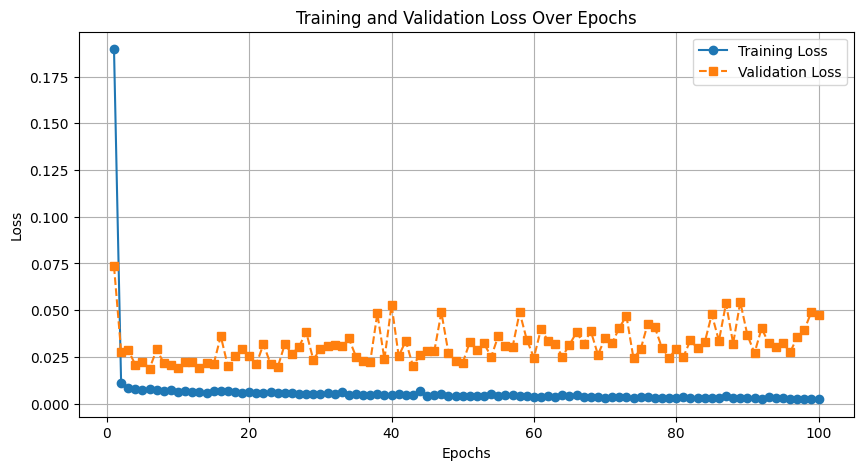

Mean Squared Error (MSE): 24207.365234
Root Mean Squared Error (RMSE): 155.587163
Mean Absolute Error (MAE): 126.429535
R² Score: 0.166109
Mean Absolute Percentage Error (MAPE): 3.28%


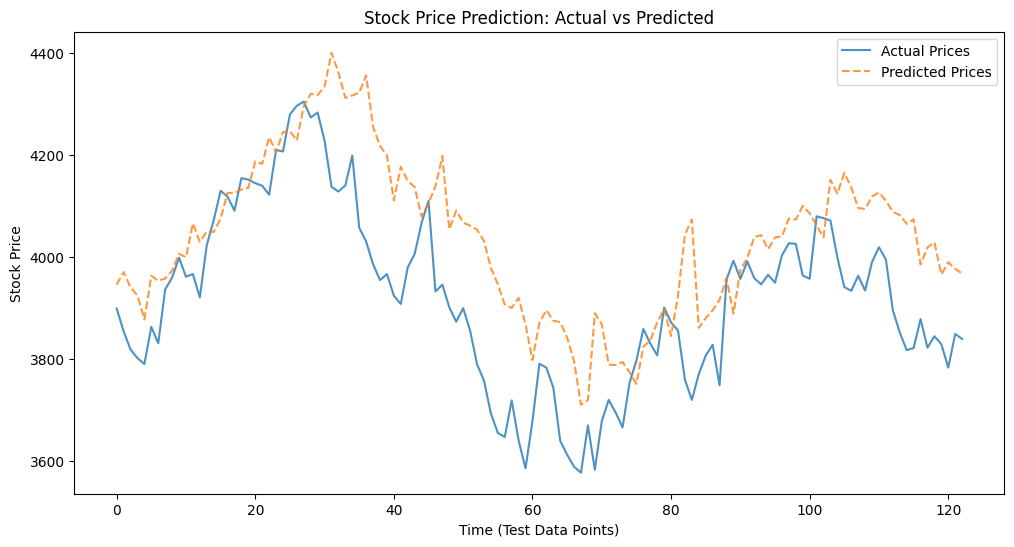

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features (all indicators + Time)
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen',
    'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R', 'Bollinger_Mavg',
    'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (70% train, 20% validation, 10% test)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

#### Test 2 Description:
**70% Training, 15% Validation, 15% Testing**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.0063, Validation Loss: 0.0155
Epoch [20/100], Train Loss: 0.0053, Validation Loss: 0.0129
Epoch [30/100], Train Loss: 0.0054, Validation Loss: 0.0145
Epoch [40/100], Train Loss: 0.0041, Validation Loss: 0.0164
Epoch [50/100], Train Loss: 0.0043, Validation Loss: 0.0191
Epoch [60/100], Train Loss: 0.0041, Validation Loss: 0.0219
Epoch [70/100], Train Loss: 0.0037, Validation Loss: 0.0156
Epoch [80/100], Train Loss: 0.0034, Validation Loss: 0.0171
Epoch [90/100], Train Loss: 0.0029, Validation Loss: 0.0187
Epoch [100/100], Train Loss: 0.0021, Validation Loss: 0.0179


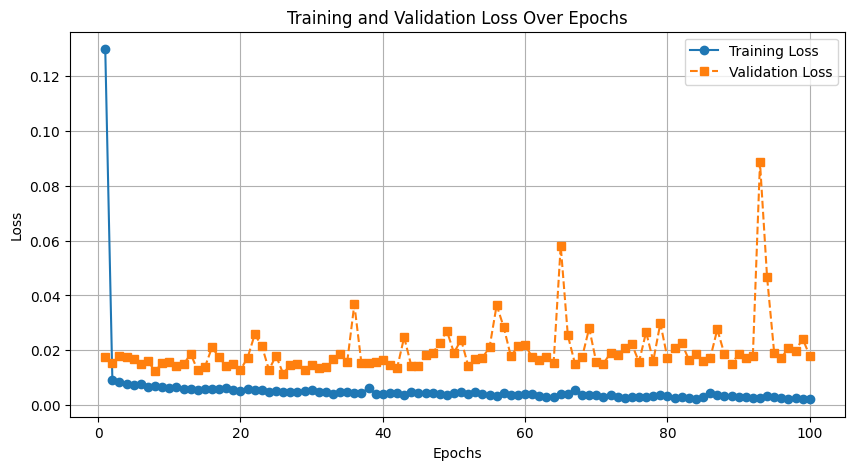

Mean Squared Error (MSE): 20309.773438
Root Mean Squared Error (RMSE): 142.512362
Mean Absolute Error (MAE): 121.001495
R² Score: 0.503499
Mean Absolute Percentage Error (MAPE): 3.09%


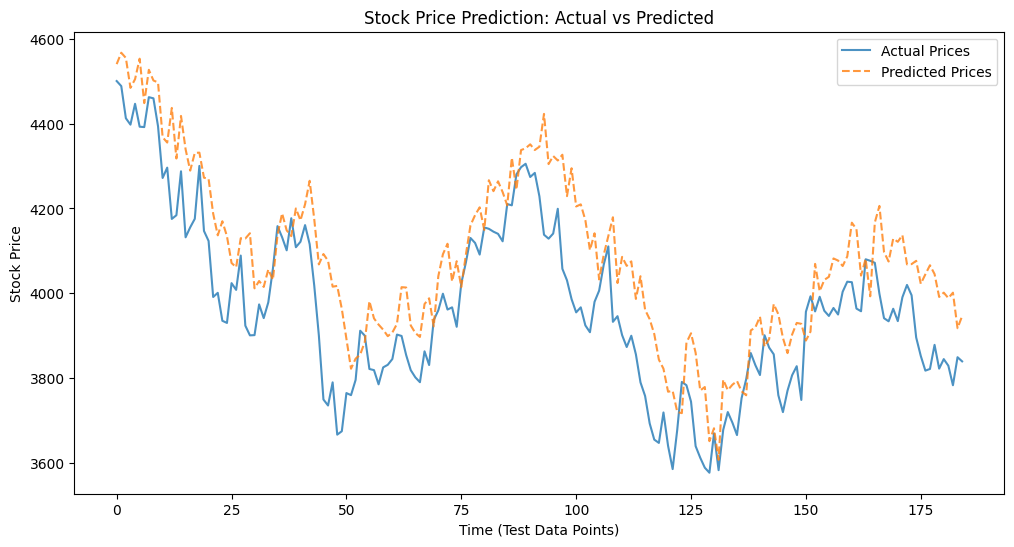

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features (all indicators + Time)
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen',
    'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R', 'Bollinger_Mavg',
    'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (70% train, 15% validation, 15% test)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

#### Test 3 Description:
**60% Training, 20% Validation, 20% Testing**

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.0148, Validation Loss: 0.0279
Epoch [20/100], Train Loss: 0.0123, Validation Loss: 0.1019
Epoch [30/100], Train Loss: 0.0129, Validation Loss: 0.0188
Epoch [40/100], Train Loss: 0.0096, Validation Loss: 0.1491
Epoch [50/100], Train Loss: 0.0086, Validation Loss: 0.0374
Epoch [60/100], Train Loss: 0.0079, Validation Loss: 0.0534
Epoch [70/100], Train Loss: 0.0066, Validation Loss: 0.1782
Epoch [80/100], Train Loss: 0.0070, Validation Loss: 0.2313
Epoch [90/100], Train Loss: 0.0050, Validation Loss: 0.0717
Epoch [100/100], Train Loss: 0.0054, Validation Loss: 0.0780


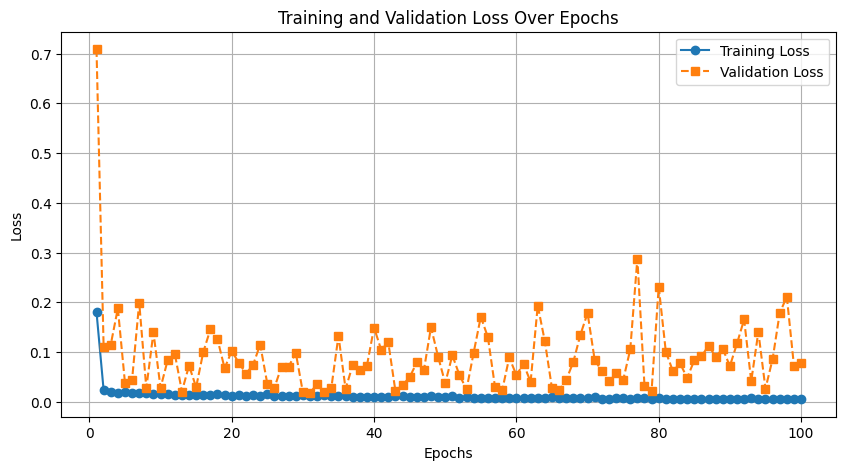

Mean Squared Error (MSE): 8098.223633
Root Mean Squared Error (RMSE): 89.990131
Mean Absolute Error (MAE): 73.205750
R² Score: 0.894926
Mean Absolute Percentage Error (MAPE): 1.79%


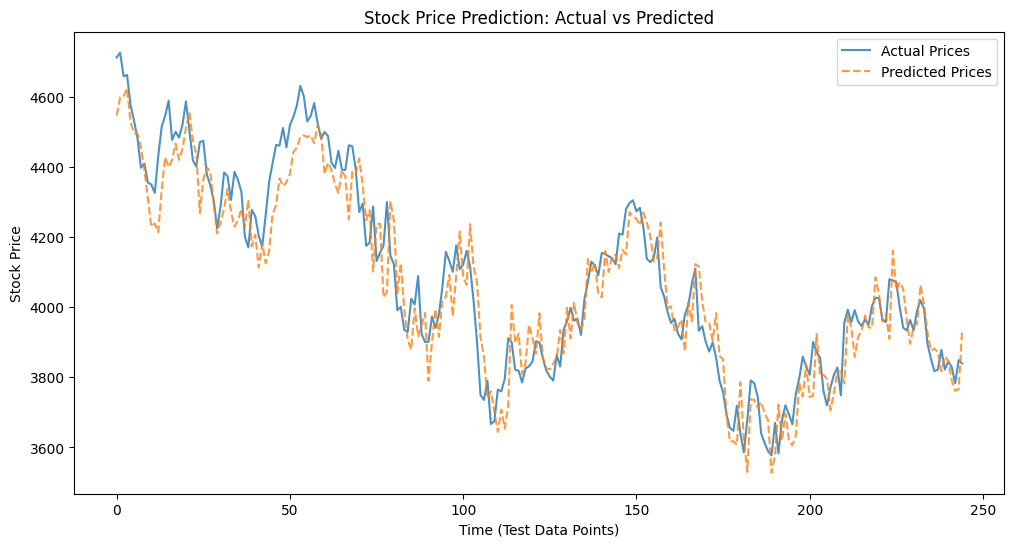

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features (all indicators + Time)
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen',
    'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R', 'Bollinger_Mavg',
    'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (60% train, 20% validation, 20% test)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

## Baseline Model Testing - Variation in Technical Indicators (as Input Features)

#### Testing Descriptions:
1. Technical Indicators used are split into 3 main categories, namely:
- Price & Trend Indicators
- Momentum Indicators
- Volatility, Volume & Market Breadth Indicators
2. Models will be using a 60% Training, 20% Validation & 20% Testing Split
3. All models in this section will have the following Model Architecture & Hyperparameters:
```
StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=len(features), out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
```
- Hyperparameters:
```
input_size = len(features) # Will vary due to the different number of features (indicators) used
hidden_size1 = 128
hidden_size2 = 64  
output_size = 1  
batch_size = 16
learning_rate = 0.001
num_epochs = 100
```

#### Test 1 Description:
**Price & Trend Indicators**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.0216, Validation Loss: 0.1024
Epoch [20/100], Train Loss: 0.0221, Validation Loss: 0.0529
Epoch [30/100], Train Loss: 0.0203, Validation Loss: 0.0439
Epoch [40/100], Train Loss: 0.0201, Validation Loss: 0.0913
Epoch [50/100], Train Loss: 0.0192, Validation Loss: 0.0433
Epoch [60/100], Train Loss: 0.0181, Validation Loss: 0.0241
Epoch [70/100], Train Loss: 0.0178, Validation Loss: 0.0602
Epoch [80/100], Train Loss: 0.0168, Validation Loss: 0.0595
Epoch [90/100], Train Loss: 0.0157, Validation Loss: 0.0789
Epoch [100/100], Train Loss: 0.0154, Validation Loss: 0.1892


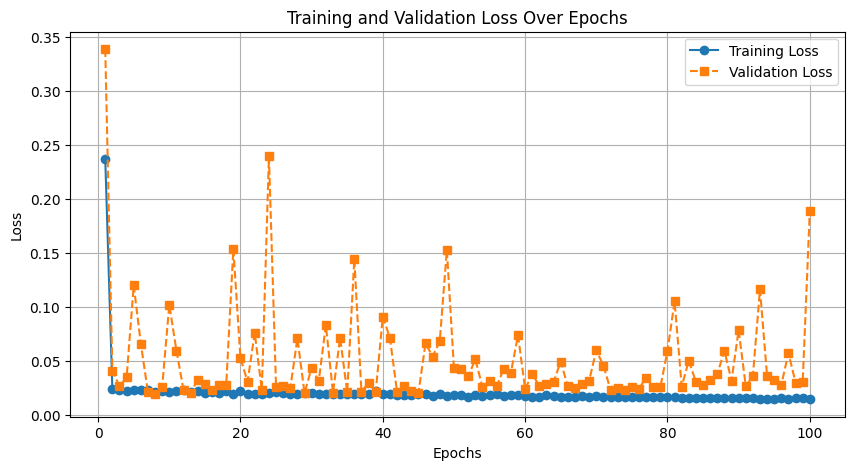

Mean Squared Error (MSE): 30667.044922
Root Mean Squared Error (RMSE): 175.120087
Mean Absolute Error (MAE): 153.404785
R² Score: 0.602097
Mean Absolute Percentage Error (MAPE): 3.78%


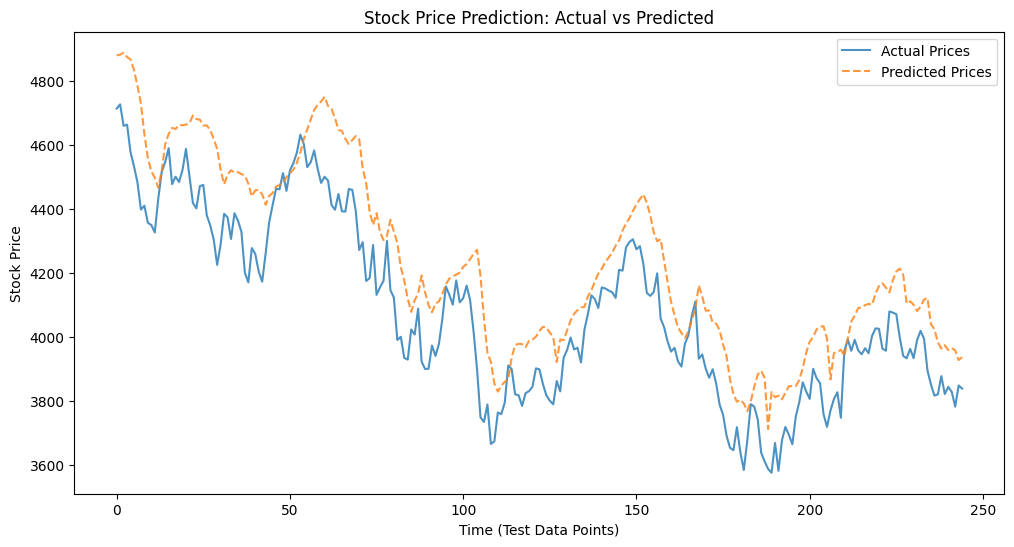

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features ('Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen')
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (60% train, 20% validation, 20% test)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

#### Test 2 Description:
**Momentum Indicators**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.1150, Validation Loss: 1.6206
Epoch [20/100], Train Loss: 0.0855, Validation Loss: 0.1269
Epoch [30/100], Train Loss: 0.0779, Validation Loss: 0.1248
Epoch [40/100], Train Loss: 0.0625, Validation Loss: 0.1570
Epoch [50/100], Train Loss: 0.0545, Validation Loss: 0.1002
Epoch [60/100], Train Loss: 0.0499, Validation Loss: 0.1256
Epoch [70/100], Train Loss: 0.0470, Validation Loss: 0.1442
Epoch [80/100], Train Loss: 0.0455, Validation Loss: 0.0946
Epoch [90/100], Train Loss: 0.0367, Validation Loss: 0.1271
Epoch [100/100], Train Loss: 0.0316, Validation Loss: 0.1040


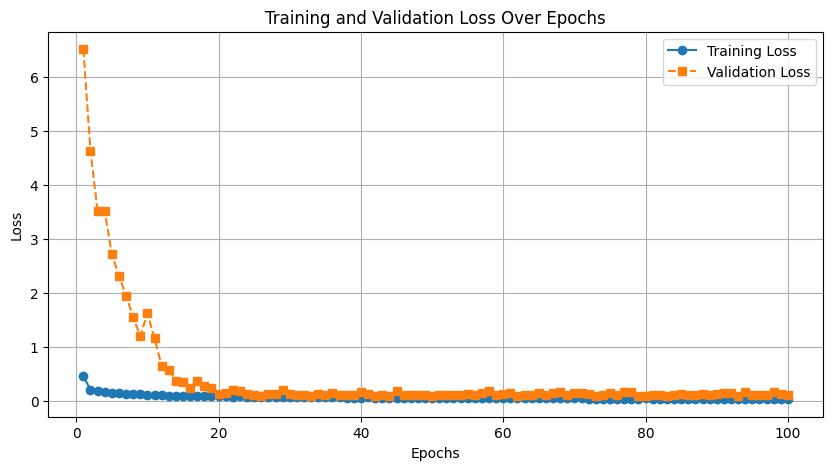

Mean Squared Error (MSE): 1633111.000000
Root Mean Squared Error (RMSE): 1277.932314
Mean Absolute Error (MAE): 1149.003540
R² Score: -20.189501
Mean Absolute Percentage Error (MAPE): 29.01%


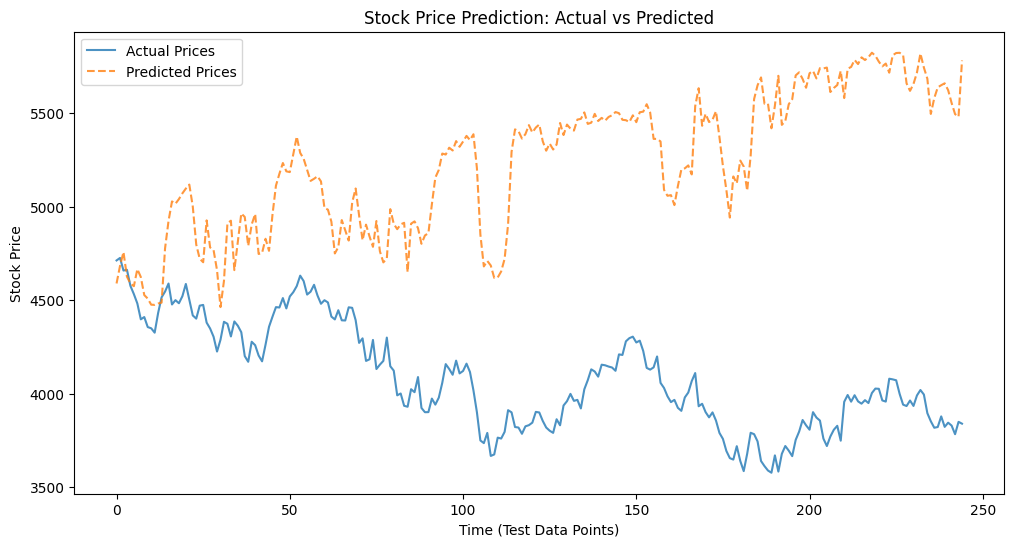

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features ('Time', 'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R')
features = [
    'Time', 'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (60% train, 20% validation, 20% test)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

#### Test 3 Description:
**Volatility & Volume Indicators**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


StockPredictionNN(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [10/100], Train Loss: 0.0197, Validation Loss: 0.0973
Epoch [20/100], Train Loss: 0.0221, Validation Loss: 0.0422
Epoch [30/100], Train Loss: 0.0183, Validation Loss: 0.1093
Epoch [40/100], Train Loss: 0.0174, Validation Loss: 0.0408
Epoch [50/100], Train Loss: 0.0139, Validation Loss: 0.0531
Epoch [60/100], Train Loss: 0.0129, Validation Loss: 0.0496
Epoch [70/100], Train Loss: 0.0121, Validation Loss: 0.0435
Epoch [80/100], Train Loss: 0.0125, Validation Loss: 0.0697
Epoch [90/100], Train Loss: 0.0138, Validation Loss: 0.0637
Epoch [100/100], Train Loss: 0.0105, Validation Loss: 0.1150


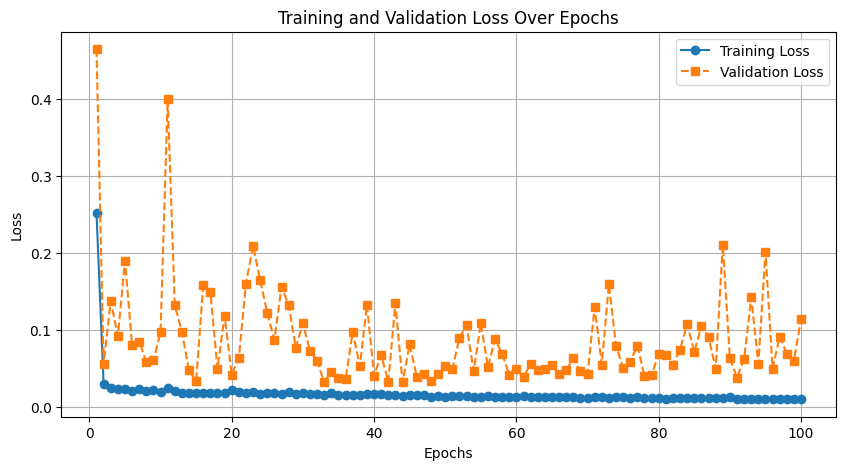

Mean Squared Error (MSE): 34374.597656
Root Mean Squared Error (RMSE): 185.403877
Mean Absolute Error (MAE): 159.066010
R² Score: 0.553992
Mean Absolute Percentage Error (MAPE): 3.97%


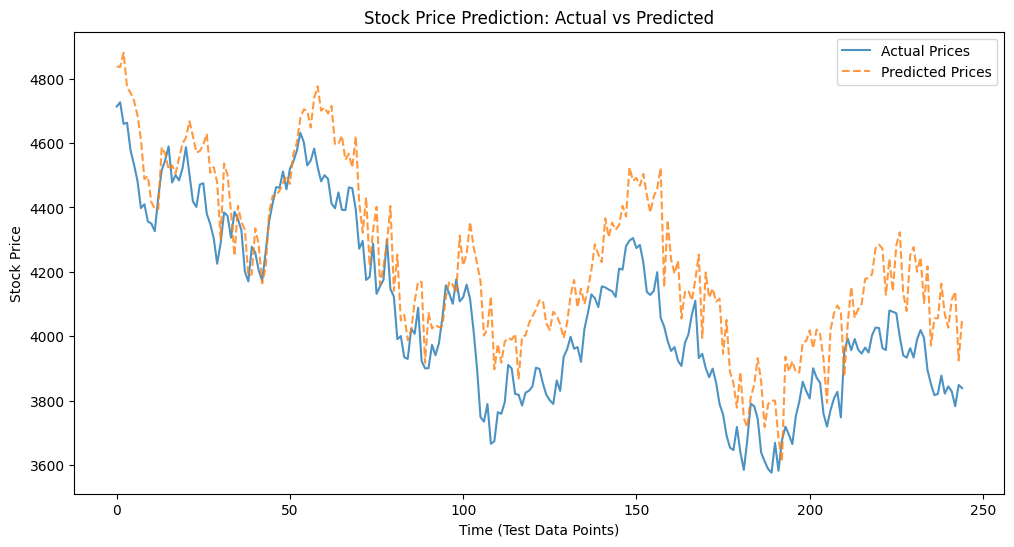

In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features ('Time', 'Bollinger_Mavg', 'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX')
features = [
    'Time', 'Bollinger_Mavg', 'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (60% train, 20% validation, 20% test)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# =============================================================================
# PART 2: Shallow Neural Network Model Creation, Training & Testing
# =============================================================================

# Define the Neural Network for Stock Prediction
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size1, out_features=hidden_size2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size2, out_features=output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value (e.g., stock price)

# Initialize model
model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)

# Print model architecture
print(model)

# Initialize loss function & optimizer
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0

    for X_train, y_train in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_train)

        # Compute the loss
        loss = criterion(y_pred, y_train)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Set the model to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = model(X_test)

        predictions.extend(y_pred.numpy())

        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# =============================================================================
# PART 3: Evaluation
# =============================================================================

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()

## Baseline Model - Hyperparameter Tuning

#### Testing Descriptions:
1. Hyperparameter Tuning done on Baseline Shallow Neural Network by using Bayesian Optimisation!
2. Hyperparameters that will be tuned:
   ```
    # Tune hyperparameters
    hidden_size1 [32, 64, 128, 256]
    hidden_size2 = [32, 64, 128]
    learning_rate = [1e-4, 1e-2]
    dropout_rate = [0.0, 0.5]
    batch_size = [16, 32, 64]
    activation_fn = ["relu", "tanh", "leaky_relu"]
```
3. Models will be using all technical indicators (combined indicators) as feature inputs
4. Model will be using a 60% Training, 20% Validation & 20% Testing Split
5. K-fold Cross Validation will be performed on both Baseline Model & Optimised Model to compare the results & performance

##### Baseline Model Evaluation using K-Fold Cross Validation

In [ ]:
# =============================================================================
# Performing K-Fold Cross Validation to evaluate Optimised Model
# =============================================================================

# Define features (all indicators + Time)
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen',
    'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R', 'Bollinger_Mavg',
    'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Initalise scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Define K-Fold Cross Validation (TimeSeriesSplit for time series data)
k_folds = 5
tscv = TimeSeriesSplit(n_splits=k_folds)

# Define the Neural Network
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StockPredictionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )
    def forward(self, x):
        return self.layers(x)

# Hyperparameters
batch_size = 16
num_epochs = 100

input_size = len(features)  # Number of input features
hidden_size1 = 128 # First hidden layer neurons
hidden_size2 = 64  # Second hidden layer neurons
output_size = 1  # Predicting one value

# Store results
cv_results = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": [],
    "mape": []
}

# Perform k-fold cross validation
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split Data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalize data
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)

    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = StockPredictionNN(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Train model
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                predictions.extend(y_pred.numpy())
                actuals.extend(y_batch.numpy())

    # Convert back to original scale
    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

    # Compute metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # Store results
    cv_results["mse"].append(mse)
    cv_results["rmse"].append(rmse)
    cv_results["mae"].append(mae)
    cv_results["r2"].append(r2)
    cv_results["mape"].append(mape)

    print(f"Fold {fold + 1}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, MAPE={mape:.2f}%")

# Print final cross-validation results
print("\nCross-Validation Results:")
print(f"Average MSE: {np.mean(cv_results['mse']):.4f}")
print(f"Average RMSE: {np.mean(cv_results['rmse']):.4f}")
print(f"Average MAE: {np.mean(cv_results['mae']):.4f}")
print(f"Average R2 Score: {np.mean(cv_results['r2']):.4f}")
print(f"Average MAPE: {np.mean(cv_results['mape']):.2f}%")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Fold 1/5
Fold 1: MSE=3360.5381, RMSE=57.9701, MAE=41.0479, R2=0.8362, MAPE=1.50%
Fold 2/5
Fold 2: MSE=38744.5703, RMSE=196.8364, MAE=113.0532, R2=0.2855, MAPE=4.11%
Fold 3/5
Fold 3: MSE=53781.3672, RMSE=231.9081, MAE=200.9023, R2=0.3340, MAPE=5.26%
Fold 4/5
Fold 4: MSE=3076.2883, RMSE=55.4643, MAE=43.2901, R2=0.8851, MAPE=0.97%
Fold 5/5
Fold 5: MSE=15954.9609, RMSE=126.3129, MAE=103.5283, R2=0.7323, MAPE=2.63%

Cross-Validation Results:
Average MSE: 22983.5450
Average RMSE: 133.6984
Average MAE: 100.3643
Average R2 Score: 0.6146
Average MAPE: 2.89%


##### Bayesian Optimisation using Optuna



In [ ]:
# =============================================================================
# PART 1: Data Pre-processing
# =============================================================================

# Define features (all indicators + Time)
features = [
    'Time', 'SMA', 'EMA', 'WMA', 'MACD', 'Parabolic_SAR', 'Ichimoku_Tenkan_sen',
    'RSI', 'Stochastic_Oscillator', 'ROC', 'MOM', 'Williams_%R', 'Bollinger_Mavg',
    'OBV', 'MFI', 'VWAP', 'Approx_AD', 'VIX'
]

# Prepare X (features) and y (actual closing prices)
X = data[features]
y = data['Y'].values.reshape(-1, 1)  # Ensure y is 2D

# Time-based split for time series (70% train, 15% validation, 15% test)
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Normalize the training and testing data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize the training, validation, and testing data
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [ ]:
# =============================================================================
# PART 2: Define the Objective Function for Optimisation
# =============================================================================

def objective(trial):

    # Fixed Hyperparameters
    input_size = len(features) # Number of input features
    output_size = 1 # Predicting one value

    # Tune hyperparameters
    hidden_size1 = trial.suggest_categorical("hidden_size1", [32, 64, 128, 256])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [32, 64, 128])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation_fn = trial.suggest_categorical("activation", ["relu", "tanh", "leaky_relu"])

    # Define the model
    class StockPredictionNN(nn.Module):
        def __init__(self):
            super(StockPredictionNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size1)
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            self.fc3 = nn.Linear(hidden_size2, output_size)
            self.dropout = nn.Dropout(dropout_rate)
            self.activation = getattr(F, activation_fn)

        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.dropout(x)
            x = self.activation(self.fc2(x))
            x = self.fc3(x)
            return x

    # Model initialization
    model = StockPredictionNN()

    # Loss function and optimiser
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Prepare new dataloaders for the chosen batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 30  # Keeping it small for fast tuning
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validation loss computation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()

    return val_loss / len(val_loader)

In [ ]:
# =============================================================================
# PART 3: Run Hyperparameter Optimisation
# =============================================================================

# Run the optimization with Optuna
study = optuna.create_study(direction="minimize")  # We want to minimize validation loss
study.optimize(objective, n_trials=30)  # Number of trials (experiments)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-03-15 06:18:24,967] A new study created in memory with name: no-name-9e342bf4-1e82-46a8-adfc-a26b938d5807
<ipython-input-10-e4fadf7c78e3>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
<ipython-input-10-e4fadf7c78e3>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
[I 2025-03-15 06:18:26,857] Trial 0 finished with value: 2.9046049807220697 and parameters: {'hidden_size1': 32, 'hidden_size2': 128, 'learning_rate': 0.0017867492829562511, 'dropout_rate': 0.3495950258206419, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 0 with value: 2.9046

Best Hyperparameters: {'hidden_size1': 128, 'hidden_size2': 32, 'learning_rate': 0.002081896423415752, 'dropout_rate': 0.2783082412106063, 'batch_size': 32, 'activation': 'relu'}


Epoch [10/100], Train Loss: 0.0277, Validation Loss: 0.1781
Epoch [20/100], Train Loss: 0.0241, Validation Loss: 0.1299
Epoch [30/100], Train Loss: 0.0216, Validation Loss: 0.1230
Epoch [40/100], Train Loss: 0.0198, Validation Loss: 0.0395
Epoch [50/100], Train Loss: 0.0166, Validation Loss: 0.0364
Epoch [60/100], Train Loss: 0.0173, Validation Loss: 0.1603
Epoch [70/100], Train Loss: 0.0152, Validation Loss: 0.1403
Epoch [80/100], Train Loss: 0.0141, Validation Loss: 0.0344
Epoch [90/100], Train Loss: 0.0139, Validation Loss: 0.0825
Epoch [100/100], Train Loss: 0.0143, Validation Loss: 0.1796


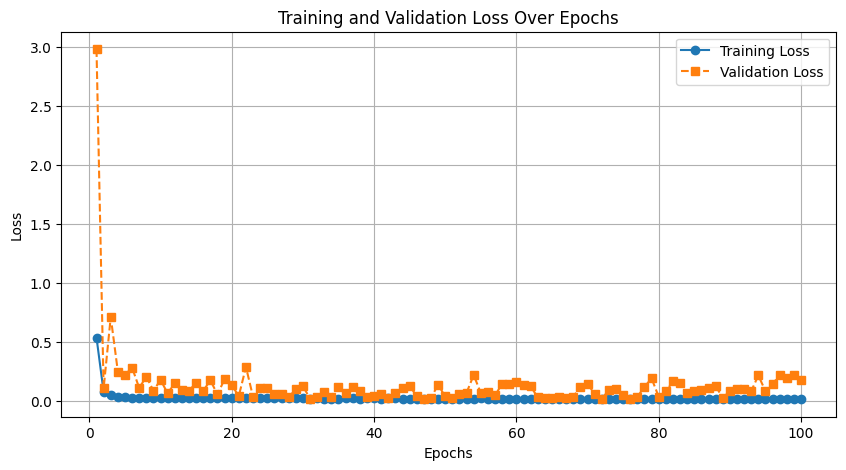

In [ ]:
# =============================================================================
# PART 4: Train the Model with Optimised Hyperparameters
# =============================================================================

# Get the best hyperparameters from Optuna tuning
best_params = study.best_params

class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate, activation_fn):
        super(StockPredictionNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = getattr(F, activation_fn)  # Dynamically set activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


# Define input size and output size
input_size = len(features)
output_size = 1

# Create final model using optimised hyperparameters
final_model = StockPredictionNN(
    input_size=input_size,
    hidden_size1=best_params["hidden_size1"],
    hidden_size2=best_params["hidden_size2"],
    output_size=output_size,
    dropout_rate=best_params["dropout_rate"],
    activation_fn=best_params["activation"]
)

# Define loss function and optimiser
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()

# Prepare DataLoaders with optimised batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Training loop
num_epochs = 100  # Full training now
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    final_model.train()
    epoch_train_loss = 0.0

    for X_batch, y_batch in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing inputs to the model
        y_pred = final_model(X_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loss computation
    final_model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = final_model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            epoch_val_loss += val_loss.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', linestyle='solid', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

Mean Squared Error (MSE): 5278.597168
Root Mean Squared Error (RMSE): 72.653955
Mean Absolute Error (MAE): 58.062939
R² Score: 0.931511
Mean Absolute Percentage Error (MAPE): 1.44%


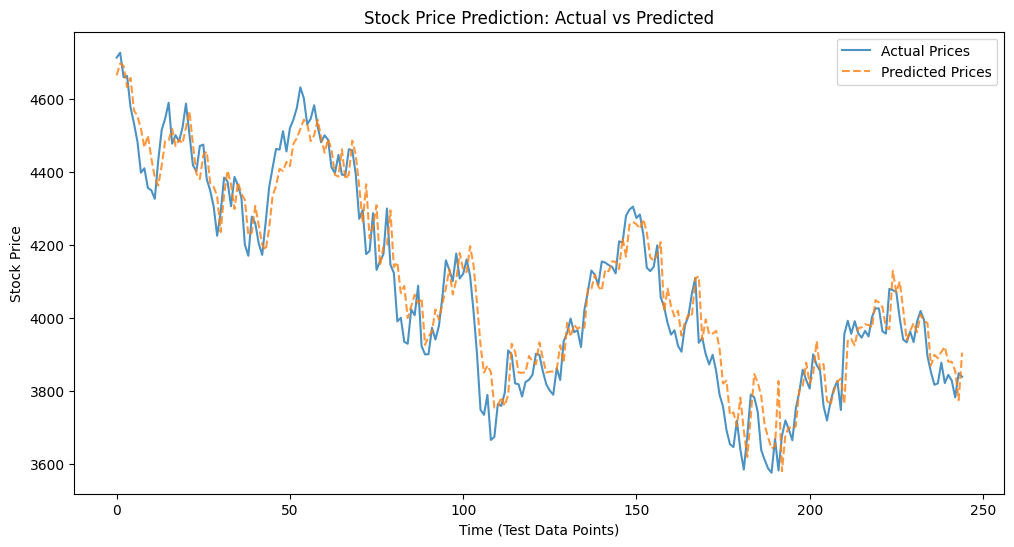

In [ ]:
# =============================================================================
# PART 5: Evaluate the Final Model
# =============================================================================

# Set model to evaluation mode
final_model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        y_pred = final_model(X_test)
        predictions.extend(y_pred.numpy())
        actuals.extend(y_test.numpy())

# Convert predictions and actuals back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", linestyle='solid', alpha=0.8)
plt.plot(predictions, label="Predicted Prices", linestyle='dashed', alpha=0.8)
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.legend()
plt.show()


##### Optimised Model Evaluation using K-Fold Cross Validation

In [ ]:
# =============================================================================
# Performing K-Fold Cross Validation to evaluate Optimised Model
# =============================================================================

# Initalise scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Define K-Fold Cross Validation (TimeSeriesSplit for time series data)
k_folds = 5
tscv = TimeSeriesSplit(n_splits=k_folds)

# Define the Neural Network
class StockPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate, activation_fn):
        super(StockPredictionNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = getattr(F, activation_fn)  # Dynamically set activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Hyperparameters
input_size = len(features)
output_size = 1
num_epochs = 100

# Create final model using optimized hyperparameters
final_model = StockPredictionNN(
    input_size=input_size,
    hidden_size1=best_params["hidden_size1"],
    hidden_size2=best_params["hidden_size2"],
    output_size=output_size,
    dropout_rate=best_params["dropout_rate"],
    activation_fn=best_params["activation"]
)

# Store results
cv_results = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": [],
    "mape": []
}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Split Data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalize data
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)

    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Prepare DataLoaders with optimized batch size
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

    # Define loss function and optimizer
    optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        final_model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = final_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    final_model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = final_model(X_batch)
            predictions.extend(y_pred.numpy())
            actuals.extend(y_batch.numpy())

    # Convert back to original scale
    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

    # Compute metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # Store results
    cv_results["mse"].append(mse)
    cv_results["rmse"].append(rmse)
    cv_results["mae"].append(mae)
    cv_results["r2"].append(r2)
    cv_results["mape"].append(mape)

    print(f"Fold {fold + 1}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, MAPE={mape:.2f}%")

# Print final cross-validation results
print("\nCross-Validation Results:")
print(f"Average MSE: {np.mean(cv_results['mse']):.4f}")
print(f"Average RMSE: {np.mean(cv_results['rmse']):.4f}")
print(f"Average MAE: {np.mean(cv_results['mae']):.4f}")
print(f"Average R2 Score: {np.mean(cv_results['r2']):.4f}")
print(f"Average MAPE: {np.mean(cv_results['mape']):.2f}%")

Fold 1/5
Fold 1: MSE=1491.4951, RMSE=38.6199, MAE=25.8502, R2=0.9273, MAPE=0.95%
Fold 2/5
Fold 2: MSE=13257.1973, RMSE=115.1399, MAE=76.3214, R2=0.7555, MAPE=2.69%
Fold 3/5
Fold 3: MSE=6580.2485, RMSE=81.1187, MAE=65.8719, R2=0.9185, MAPE=1.73%
Fold 4/5
Fold 4: MSE=3101.8259, RMSE=55.6940, MAE=40.0709, R2=0.8842, MAPE=0.90%
Fold 5/5
Fold 5: MSE=11349.9346, RMSE=106.5361, MAE=87.0458, R2=0.8096, MAPE=2.22%

Cross-Validation Results:
Average MSE: 7156.1403
Average RMSE: 79.4217
Average MAE: 59.0320
Average R2 Score: 0.8590
Average MAPE: 1.70%


# END OF CODES